<a href="https://colab.research.google.com/github/ce888-sr/CE888/blob/master/A2/CE888_Assignment2_Model3_FineTuning(95).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, Dropout, Dense, Conv2D, Flatten, Dropout, ReLU, MaxPool2D, BatchNormalization, SeparableConv2D, Add, GlobalAvgPool2D, GlobalAveragePooling2D
import cv2

#from plotdata import plot_training

In [122]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#download and unzip files
!unzip  "/content/gdrive/My Drive/Training (2).zip"
!unzip  "/content/gdrive/My Drive/Test (1).zip"

Streaming output truncated to the last 5000 lines.
  inflating: Test/Fire/resized_test_fire_frame3884.jpg  
  inflating: Test/Fire/resized_test_fire_frame3888.jpg  
  inflating: Test/Fire/resized_test_fire_frame3889.jpg  
  inflating: Test/Fire/resized_test_fire_frame3895.jpg  
  inflating: Test/Fire/resized_test_fire_frame3896.jpg  
  inflating: Test/Fire/resized_test_fire_frame39.jpg  
  inflating: Test/Fire/resized_test_fire_frame3917.jpg  
  inflating: Test/Fire/resized_test_fire_frame3920.jpg  
  inflating: Test/Fire/resized_test_fire_frame3939.jpg  
  inflating: Test/Fire/resized_test_fire_frame3943.jpg  
  inflating: Test/Fire/resized_test_fire_frame395.jpg  
  inflating: Test/Fire/resized_test_fire_frame3953.jpg  
  inflating: Test/Fire/resized_test_fire_frame3954.jpg  
  inflating: Test/Fire/resized_test_fire_frame3958.jpg  
  inflating: Test/Fire/resized_test_fire_frame3959.jpg  
  inflating: Test/Fire/resized_test_fire_frame396.jpg  
  inflating: Test/Fire/resized_test_fire_

In [123]:
train_directory = "/content/Training" #set directory to where the extracted datsets are saved
test_directory = '/content/Test'

In [124]:
#set image size and batch size
image_size = (254, 254)
batch_size = 32

In [125]:
#add data augmentation techniques to the training datagen and add rescale to all datagens
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,0.9],
    validation_split=0.2)


val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [126]:
#create datasets for training, validation and testing
train_ds = train_datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed = 1337,
    subset='training') # set as training data

val_ds = val_datagen.flow_from_directory(
    train_directory, # same directory as training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed = 1337,
    subset='validation') # set as validation data

test_ds = test_datagen.flow_from_directory(test_directory,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle = False)

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [147]:
#load pre trained Xception model
from keras.models import Model
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras import regularizers

from keras.models import Model
#load pre trained Xception model
base_model = Xception(input_shape=(254, 254, 3), weights='imagenet', include_top=False) #define model
x = base_model.output

# add additional layers
x = GlobalAveragePooling2D()(x) #convert features to vectors
x = Dropout(0.5)(x) # add dropout 0.5
x = Dense(2048, activation = 'relu')(x)
x = Dropout(0.5)(x) # add dropout 0.5
output = Dense(1, activation='sigmoid')(x) #2 classes

#freeze the pre-trained base_model
for layer in base_model.layers: 
        layer.trainable = False 

model = Model(base_model.input, output)

#model.summary()

In [148]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-6), #low learning rate 
                  loss='binary_crossentropy',  # binary_crossentropy for binary classifier
                  metrics=['accuracy'])

In [149]:
#set early stopping and model weights checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = 'top_model.hdf5'
callbacks_list = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True), #patience set to 5 to stop overfitting
    ModelCheckpoint(filepath, monitor ="val_loss", mode="min", save_best_only=True)]

In [150]:
epochs = 40
history = model.fit(train_ds,
          steps_per_epoch = 100, 
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=val_ds,
          #class_weight=class_weight,
          callbacks = callbacks_list)

Epoch 1/40
100/100 [==============================] - 74s 720ms/step - loss: 0.7586 - accuracy: 0.4559 - val_loss: 0.6168 - val_accuracy: 0.8915
Epoch 2/40
100/100 [==============================] - 72s 725ms/step - loss: 0.6531 - accuracy: 0.6058 - val_loss: 0.5402 - val_accuracy: 0.9662
Epoch 3/40
100/100 [==============================] - 72s 719ms/step - loss: 0.5853 - accuracy: 0.7301 - val_loss: 0.4880 - val_accuracy: 0.9671
Epoch 4/40
100/100 [==============================] - 72s 718ms/step - loss: 0.5438 - accuracy: 0.7891 - val_loss: 0.4473 - val_accuracy: 0.9835
Epoch 5/40
100/100 [==============================] - 72s 723ms/step - loss: 0.5090 - accuracy: 0.7995 - val_loss: 0.4144 - val_accuracy: 0.9962
Epoch 6/40
100/100 [==============================] - 72s 720ms/step - loss: 0.4930 - accuracy: 0.8255 - val_loss: 0.3889 - val_accuracy: 0.9986
Epoch 7/40
100/100 [==============================] - 73s 732ms/step - loss: 0.4734 - accuracy: 0.8198 - val_loss: 0.3665 - val_ac

In [151]:
for layer in model.layers[:95]:
 layer.trainable = False
for layer in model.layers[95:]:
 layer.trainable = True

In [152]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
                  loss='binary_crossentropy',  # binary_crossentropy for binary classifier
                  metrics=['accuracy'])

In [153]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath='final_model.hdf5'
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10,  verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor ="val_loss", mode="min", save_best_only=True)]

In [154]:
history_1 = model.fit(train_ds,
          steps_per_epoch = 100,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=val_ds,
          callbacks = my_callbacks)

Epoch 1/40
100/100 [==============================] - 78s 743ms/step - loss: 0.2061 - accuracy: 0.9139 - val_loss: 0.0569 - val_accuracy: 0.9702
Epoch 2/40
100/100 [==============================] - 74s 738ms/step - loss: 0.0528 - accuracy: 0.9818 - val_loss: 0.0565 - val_accuracy: 0.9787
Epoch 3/40
100/100 [==============================] - 73s 730ms/step - loss: 0.0217 - accuracy: 0.9923 - val_loss: 0.2125 - val_accuracy: 0.9514
Epoch 4/40
100/100 [==============================] - 73s 732ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.1974 - val_accuracy: 0.9529
Epoch 5/40
100/100 [==============================] - 74s 737ms/step - loss: 0.0120 - accuracy: 0.9947 - val_loss: 0.1764 - val_accuracy: 0.9506
Epoch 6/40
100/100 [==============================] - 74s 739ms/step - loss: 0.0111 - accuracy: 0.9969 - val_loss: 0.1923 - val_accuracy: 0.9590
Epoch 7/40
100/100 [==============================] - 74s 739ms/step - loss: 0.0195 - accuracy: 0.9919 - val_loss: 0.1453 - val_ac

In [155]:
test_ds.reset()
train_ds.reset()
val_ds.reset()

In [196]:
from sklearn.metrics import accuracy_score

testLabels = test_ds.classes.astype('int32')


## Test Accuracy
predictions = model.predict(test_ds)
y_pred = np.asarray(predictions).astype('int32').reshape((-1, 1))
y_pred = [1 if i> 0.5 else 0 for i in predictions]

test_acc = accuracy_score(testLabels, y_pred)

print(test_acc)

0.6654288035279099


In [157]:
#test_scores.reset()
test_scores = model.evaluate(test_ds, batch_size=batch_size)

270/270 [==============================] - 26s 96ms/step - loss: 1.5019 - accuracy: 0.6654


In [160]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(testLabels, y_pred, average='binary')

auc = roc_auc_score(testLabels, y_pred)

In [200]:
from sklearn.metrics import confusion_matrix, classification_report


fire_eval = confusion_matrix(testLabels, y_pred)
print(fire_eval)

target_names = ['Fire', 'No Fire']
print(classification_report(testLabels, y_pred, target_names=target_names))

[[4484  653]
 [2230 1250]]
              precision    recall  f1-score   support

        Fire       0.67      0.87      0.76      5137
     No Fire       0.66      0.36      0.46      3480

    accuracy                           0.67      8617
   macro avg       0.66      0.62      0.61      8617
weighted avg       0.66      0.67      0.64      8617



In [202]:
fire_eval[0][0]

4484

In [197]:
print(y_pred)

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [218]:
tp = fire_eval[0][0]
fp = fire_eval[0][1]
tn = fire_eval[1][0]
fn = fire_eval[1][1]
conmat = np.array([[tp, fn], [fp, tn]], dtype=int)

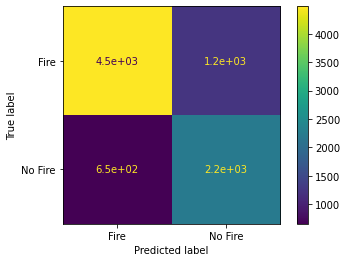

In [227]:
#plotconfusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cmat = ConfusionMatrixDisplay(confusion_matrix=cm,

                              display_labels=target_names)
cmat.plot() 

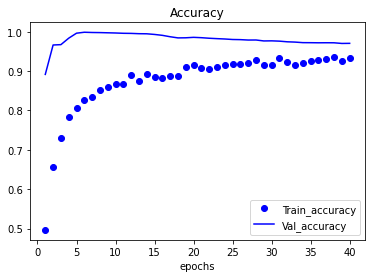

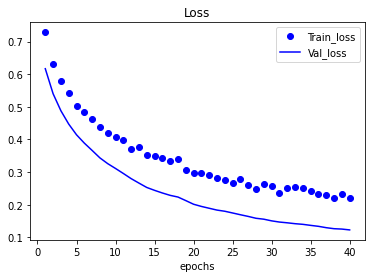

In [229]:
#create accuracy and loss plots over epochs
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train_accuracy')
plt.plot(epochs, val_acc, 'b', label='Val_accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train_loss')
plt.plot(epochs, val_loss, 'b', label='Val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [222]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
